## Time Series-Sentiment forecasting

### Import libraries

In [15]:

import numpy as np
import pandas as pd
import gzip                            # to extract file from zip file
import json  

#decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity
from statsmodels.tsa.stattools import acf,pacf,adfuller

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# plots
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

# Ljung-Box test for model goodness
import statsmodels.api as sm
# resampling
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

### Importing data set

In [16]:
office_sent = pd.read_csv("C:/Users/sandp/Downloads/office_data_final.csv")

In [17]:
office_sent['title'].value_counts()

Prismacolor 3598T Premier Colored Pencils, Soft Core, 48 Pack                                                                                                                                                1953
Sharpie 37003 Ultra-Fine Permanent Marker, Marks on Paper and Plastic, Resist Fading and Water, AP Certified, Blue Color, Pack of 12                                                                         1420
Pilot G2 Retractable Premium Gel Ink Roller Ball Pens Fine Pt (.7) Dozen Box Red ; Retractable, Refillable &amp; Premium Comfort Grip; Smooth Lines to the End of the Page, Americas #1 Selling Pen Brand    1314
Sharpie Permanent Markers, Fine Point, Purple, 12-Pack (30008)                                                                                                                                               1235
Canon Office and Business MX922 All-In-One Printer, Wireless and mobile printing                                                                                

In [18]:
#Extracting month from date
office_sent['date']=pd.to_datetime(office_sent['date'])
office_sent['Month'] = office_sent['date'].dt.month 

In [19]:
office_sent1=office_sent[office_sent['title']=='Prismacolor 3598T Premier Colored Pencils, Soft Core, 48 Pack']

In [20]:
office_sent1['title'].value_counts()

Prismacolor 3598T Premier Colored Pencils, Soft Core, 48 Pack    1953
Name: title, dtype: int64

In [21]:
# Resampling
office_pos = office_sent1[office_sent['Sentiment']=='Positive']
office_neu = office_sent1[office_sent['Sentiment']=='Neutral']
office_neg = office_sent1[office_sent['Sentiment']=='Negative']
 

### Taking month wise count of sentiment for products

In [22]:
office_pos_count=office_pos.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
office_pos_count

,asin,Month,Sentiment,sentiment_count
0,B00006IEEV,1,Positive,222
1,B00006IEEV,2,Positive,171
2,B00006IEEV,3,Positive,181
3,B00006IEEV,4,Positive,172
4,B00006IEEV,5,Positive,132
5,B00006IEEV,6,Positive,92
6,B00006IEEV,7,Positive,115
7,B00006IEEV,8,Positive,143
8,B00006IEEV,9,Positive,121
9,B00006IEEV,10,Positive,107


In [23]:
office_pos=pd.merge(office_pos,office_pos_count)

### Time series analysis

In [24]:
office_pos=office_pos[['date','sentiment_count']]
office_pos=office_pos.set_index('date')
office_pos=office_pos.sort_values(by=['date'])
office_pos

,sentiment_count
date,
2009-03-15,181
2009-05-23,132
2009-09-13,121
2009-11-04,145
2010-02-01,171
...,...
2018-05-08,132
2018-05-09,132
2018-05-12,132


### Resampling monthwise

In [25]:
office_pos=office_pos.resample('M').mean()
office_pos.head()

,sentiment_count
date,
2009-03-31,181.0
2009-04-30,NaN
2009-05-31,132.0
2009-06-30,NaN
2009-07-31,NaN


In [26]:
#office_pos.tail()

In [27]:
office_pos.isnull().sum()

sentiment_count    22
dtype: int64

In [28]:
office_pos.dropna(inplace=True)

### Defining functions for time series analysis

In [29]:
# stationarity check
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    print('pvalue:',pvalue)

    if pvalue < 0.05:
        msg = "Data is Stationary. Proceed to model building"
    else:
        msg = " Data is not Stationary. Make the data stationary before model building"

    return msg

# Decomposition
def tsa_comp(df):
    decomp = seasonal_decompose(df, period=12, model='additive')
    d_trend = decomp.trend
    d_seasonal = decomp.seasonal
    d_resid = decomp.resid
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8), facecolor='linen')
    plt.xlabel('date')
    plt.ylabel('count of sentiment')
    plt.suptitle('TIME SERIES COMPONENT ANALYSIS', fontweight='bold', size=20)
    ax1.plot(df, label='Actual Sales')
    ax2.plot(d_trend, label='Trend', c='green')
    ax3.plot(d_seasonal, label='Seasonal', c='orange')
    ax4.plot(d_resid, label='Irregularity', c='pink')
    fig.legend();
    
 # acf and pacf plots
def p_and_q(data):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    plot_acf(data,lags=10,ax=ax[0])
    plot_pacf(data,lags=10,ax=ax[1]);

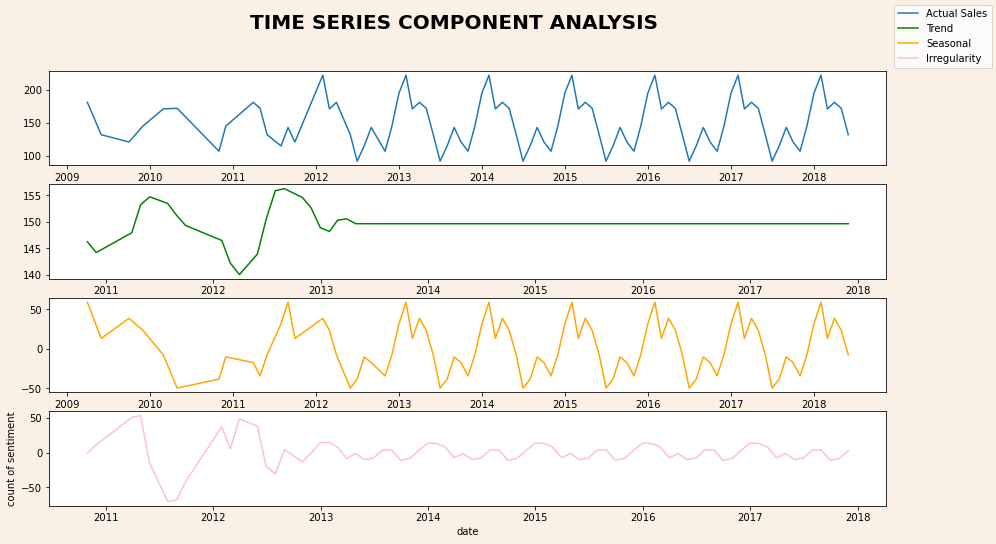

In [30]:
tsa_comp(office_pos)

In [31]:
checkStationarity(office_pos)

pvalue: 3.230592860492903e-10


'Data is Stationary. Proceed to model building'

In [18]:
#diff_office_pos = office_pos-office_pos.shift(1)
#print(diff_office_pos)

            sentiment_count
date                       
2000-03-31              NaN
2000-04-30         0.000000
2000-08-31         0.000000
2000-09-30         0.000000
2000-12-31         0.000000
...                     ...
2018-05-31        -0.410189
2018-06-30        -0.182356
2018-07-31         0.014632
2018-08-31        -0.043578
2018-09-30         0.148061

[197 rows x 1 columns]


### Splitting

In [32]:
ratio = 0.7
rows = int(ratio * len(office_pos))
train1 =office_pos[:rows]
test1 = office_pos[rows:]

print("Total={}, Train={}, Test={}".format(len(office_pos), len(train1), len(test1)))

Total=89, Train=62, Test=27


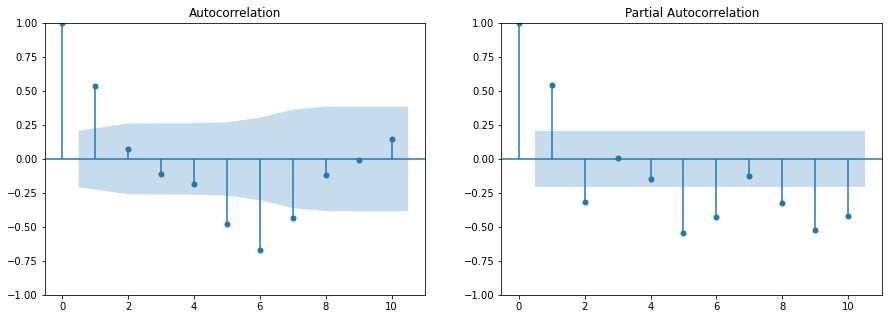

In [33]:
p_and_q(office_pos)

In [34]:
d=0;
lis=[]
for p in range(4):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train1, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model


In [35]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train1), end=len(train1)+len(test1)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test1, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results1 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results1

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",624.198303,628.452572,1307.305129,36.156675
1,Model 1,"(0, 0, 1)",605.930051,612.311454,1314.965111,36.262448
2,Model 2,"(0, 0, 2)",603.824630,612.333168,1325.154555,36.402672
3,Model 3,"(0, 0, 3)",597.486151,608.121823,1422.227297,37.712429
4,Model 4,"(1, 0, 0)",608.213006,614.594409,1293.561162,35.966111
5,Model 5,"(1, 0, 1)",606.052185,614.560723,1307.697049,36.162094
6,Model 6,"(1, 0, 2)",604.515016,615.150688,1328.115100,36.443314
7,Model 7,"(1, 0, 3)",592.998357,605.761164,1371.134483,37.028833
8,Model 8,"(2, 0, 0)",603.899140,612.407677,1359.733644,36.874566
9,Model 9,"(2, 0, 1)",587.998755,598.634427,1328.337834,36.446369


In [36]:
print('Taking model with lowest RMSE score:')
df_results1[df_results1.RMSE==df_results1.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
15,Model 15,"(3, 0, 3)",574.818153,591.835228,538.051167,23.19593


In [37]:
print('Taking model with lowest BIC score:')

df_results1[df_results1.BIC==df_results1.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
15,Model 15,"(3, 0, 3)",574.818153,591.835228,538.051167,23.19593


In [38]:
print('Taking model with lowest AIC score:')
df_results1[df_results1.AIC==df_results1.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
15,Model 15,"(3, 0, 3)",574.818153,591.835228,538.051167,23.19593


In [40]:
p=3;q=3;d=0
P=1;Q=1;D=0
m1 =sm.tsa.statespace.SARIMAX(office_pos['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
#m1=ARIMA(office_pos['sentiment_count'],order=(p,d,q)).fit()
# summarise the model
m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                   89
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -397.173
Date:                              Wed, 25 Jan 2023   AIC                            812.345
Time:                                      14:38:56   BIC                            834.743
Sample:                                           0   HQIC                           821.373
                                               - 89                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1127      0.336      3.314      0.001       0.455       1.771
ar.L2         -0.5202      0.447     -1.165      0.244      -1.395       0.355
ar.L3          0.4064      0.192      2.116      0.034       0.030       0.783
ma.L1         -0.5001      0.342     -1.464      0.143      -1.170       0.169
ma.L2         -0.0110      0.259     -0.043      0.966      -0.519       0.497
ma.L3         -0.4489      0.207     -2.164      0.030      -0.856      -0.042
ar.S.L12       0.9101      0.089     10.262      0.000       0.736       1.084
ma.S.L12      -0.3928      0.212     -1.856      0.063      -0.808       0.022
sigma2       366.3724     52.343      6.999      0.000     263.782     468.963
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               103.08
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [42]:
start = len(train1) 
end = len(train1) + len(test1) - 1

print('start = {}, end = {}'.format(start,end))

start = 62, end = 88


In [43]:
predictions = m1.predict(start,end)
predictions.index=test1.index
print(predictions.head(5))

date
2016-03-31    176.106416
2016-04-30    169.210428
2016-05-31    139.039881
2016-06-30     98.829852
2016-07-31    113.095077
Name: predicted_mean, dtype: float64


In [44]:
actual = []; pred = []
test1.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test1['sentiment_count'][i])
    pred.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res1['error'] = df_res1.actual - df_res1.predicted
df_res1.index=test1.index
print(df_res1.head())

            actual   predicted     error
date                                    
2016-03-31   181.0  176.106416  4.893584
2016-04-30   172.0  169.210428  2.789572
2016-05-31   132.0  139.039881 -7.039881
2016-06-30    92.0   98.829852 -6.829852
2016-07-31   115.0  113.095077  1.904923


In [45]:
office_pos.tail()

,sentiment_count
date,
2018-01-31,222.0
2018-02-28,171.0
2018-03-31,181.0
2018-04-30,172.0
2018-05-31,132.0


In [46]:
mse1=mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
print('mse:',mse1)
print('rmse:',rmse1)

mse: 21.56493599690046
rmse: 4.643806197172795


Text(0.5, 1.0, 'SARIMA Model. Order=(3,0,3)')

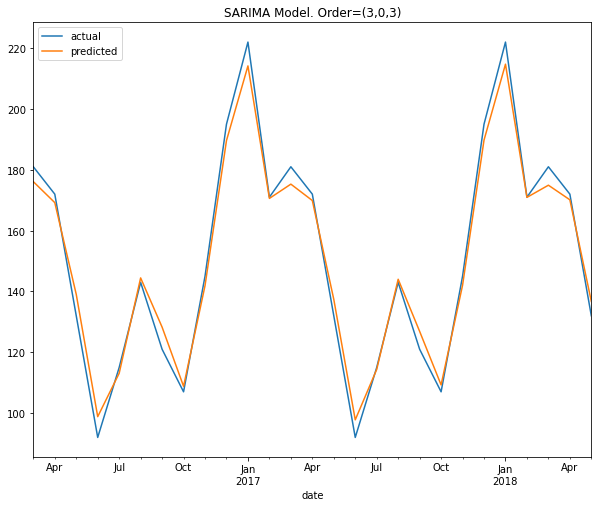

In [47]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.title(msg)

In [56]:
future_dates=pd.DataFrame()
future_dates['date']=[     
'2018-05-31',    
'2018-07-30',       
'2018-11-30',   
'2019-01-31',  
'2019-02-28',   
'2019-03-31',
'2019-05-31']      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)


In [57]:
fcast1 = m1.predict(end,end+6).rename('Forecast')
fcast1.index=future_dates.date
print(fcast1.head())

date
2018-05-31    136.726981
2018-07-30     97.354351
2018-11-30    118.111481
2019-01-31    144.512881
2019-02-28    125.744672
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of positive sentiment'>

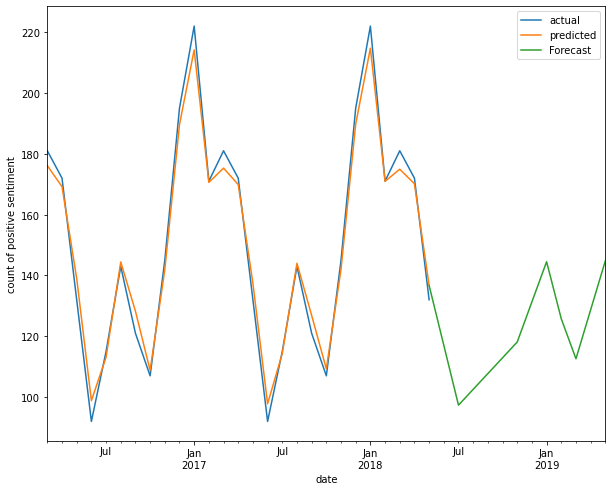

In [59]:

df_res1.actual.tail(30).plot(figsize=(10,8),legend=True)
df_res1.predicted.tail(30).plot(legend=True)
plt.ylabel('count of positive sentiment')
fcast1.plot(legend=True)

### Neutral

In [60]:
office_neu_count=office_neu.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
office_neu_count

,asin,Month,Sentiment,sentiment_count
0,B00006IEEV,1,Neutral,8
1,B00006IEEV,2,Neutral,5
2,B00006IEEV,3,Neutral,7
3,B00006IEEV,4,Neutral,6
4,B00006IEEV,5,Neutral,8
5,B00006IEEV,6,Neutral,9
6,B00006IEEV,7,Neutral,6
7,B00006IEEV,8,Neutral,15
8,B00006IEEV,9,Neutral,4
9,B00006IEEV,10,Neutral,2


In [61]:
office_neu=pd.merge(office_neu,office_neu_count)

In [62]:
office_neu=office_neu[['date','sentiment_count']]
office_neu=office_neu.set_index('date')
office_neu=office_neu.sort_values(by=['date'])
office_neu

,sentiment_count
date,
2011-08-20,15
2012-06-15,9
2013-08-02,15
2013-11-01,8
2013-11-27,8
...,...
2018-03-05,7
2018-03-28,7
2018-03-28,7


In [63]:
office_neu=office_neu.resample('M').mean()
office_neu

,sentiment_count
date,
2011-08-31,15.0
2011-09-30,NaN
2011-10-31,NaN
2011-11-30,NaN
2011-12-31,NaN
...,...
2018-01-31,8.0
2018-02-28,5.0
2018-03-31,7.0


In [64]:
office_neu.isnull().sum()

sentiment_count    42
dtype: int64

In [65]:
office_neu.dropna(inplace=True)

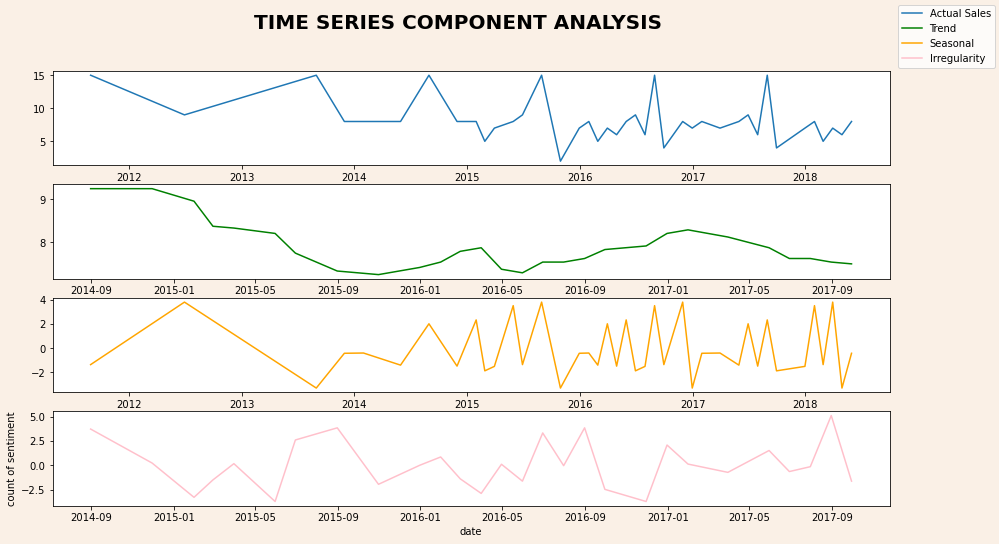

In [66]:
tsa_comp(office_neu)

In [67]:
checkStationarity(office_neu)

pvalue: 2.262244868593271e-12


'Data is Stationary. Proceed to model building'

In [69]:
#diff_office_neu = office_neu-office_neu.shift(1)
#print(diff_office_neu)

            sentiment_count
date                       
2000-05-31              NaN
2000-06-30         0.000000
2000-09-30         0.333333
2000-10-31         1.000000
2001-02-28        -1.333333
...                     ...
2018-05-31         0.079908
2018-06-30        -0.318184
2018-07-31        -0.364335
2018-08-31        -0.071818
2018-09-30         0.115152

[190 rows x 1 columns]


In [70]:
#diff_office_neu.dropna(inplace=True)

In [71]:
#checkStationarity(diff_office_neu)

pvalue: 4.0762493817565416e-10


'Data is Stationary. Proceed to model building'

In [68]:
ratio = 0.7
rows = int(ratio * len(office_neu))
train2 =office_neu[:rows]
test2 = office_neu[rows:]

print("Total={}, Train={}, Test={}".format(len(office_neu), len(train2), len(test2)))

Total=40, Train=28, Test=12


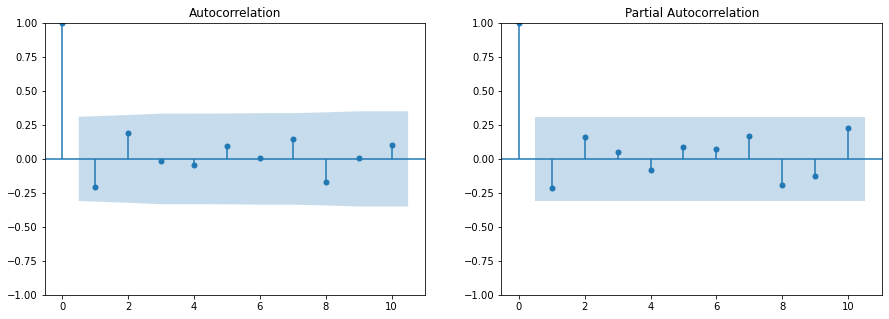

In [69]:
p_and_q(office_neu)

In [70]:
d=0;
lis=[]
for p in range(4):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train2, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model


In [71]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train2), end=len(train2)+len(test2)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test2, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results2 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results2

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",151.933097,154.597506,7.916657,2.813655
1,Model 1,"(0, 0, 1)",153.253783,157.250397,7.881133,2.807336
2,Model 2,"(0, 0, 2)",154.535294,159.864112,7.894924,2.809791
3,Model 3,"(0, 0, 3)",156.244974,162.905996,7.903328,2.811286
4,Model 4,"(1, 0, 0)",153.024201,157.020815,7.869295,2.805226
5,Model 5,"(1, 0, 1)",154.545539,159.874357,7.879566,2.807056
6,Model 6,"(1, 0, 2)",156.294001,162.955023,7.865442,2.804540
7,Model 7,"(1, 0, 3)",158.242008,166.235235,7.895852,2.809956
8,Model 8,"(2, 0, 0)",154.373160,159.701978,7.865859,2.804614
9,Model 9,"(2, 0, 1)",156.356864,163.017886,7.858758,2.803348


In [72]:
print('Taking model with lowest RMSE score:')
df_results2[df_results2.RMSE==df_results2.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
13,Model 13,"(3, 0, 1)",158.342129,166.335356,7.850497,2.801874


In [73]:
print('Taking model with lowest BIC score:')

df_results2[df_results2.BIC==df_results2.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",151.933097,154.597506,7.916657,2.813655


In [74]:
print('Taking model with lowest AIC score:')
df_results2[df_results2.AIC==df_results2.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",151.933097,154.597506,7.916657,2.813655


In [75]:
p=3;q=1;d=0
P=1;Q=1;D=0
m2 =sm.tsa.statespace.SARIMAX(office_neu['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    sentiment_count   No. Observations:                   40
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -104.464
Date:                            Wed, 25 Jan 2023   AIC                            222.929
Time:                                    14:48:25   BIC                            234.751
Sample:                                         0   HQIC                           227.203
                                             - 40                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6689      0.834      0.802      0.423      -0.966       2.304
ar.L2          0.3598      0.336      1.070      0.284      -0.299       1.019
ar.L3         -0.0289      0.256     -0.113      0.910      -0.531       0.473
ma.L1         -0.8086      0.210     -3.842      0.000      -1.221      -0.396
ar.S.L12       0.9829      1.280      0.768      0.443      -1.526       3.492
ma.S.L12      -0.9988      9.648     -0.104      0.918     -19.908      17.910
sigma2         9.8613     75.513      0.131      0.896    -138.142     157.865
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 6.63
Prob(Q):                              0.60   Prob(JB):                         0.04
Heteroskedasticity (H):               0.49   Skew:                             0.96
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [77]:
start = len(train2) 
end = len(train2) + len(test2) - 1

print('start = {}, end = {}'.format(start,end))

start = 28, end = 39


In [78]:
predictions = m2.predict(start,end)
predictions.index=test2.index
print(predictions.head())

date
2017-03-31    7.596545
2017-05-31    7.847546
2017-06-30    7.431888
2017-07-31    7.453286
2017-08-31    8.186576
Name: predicted_mean, dtype: float64


In [79]:
actual = []; pred = []
test2.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test2['sentiment_count'][i])
    pred.append(predictions[i])

df_res2 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res2['error'] = df_res2.actual - df_res2.predicted
df_res2.index=test2.index
print(df_res2.head())

            actual  predicted     error
date                                   
2017-03-31     7.0   7.596545 -0.596545
2017-05-31     8.0   7.847546  0.152454
2017-06-30     9.0   7.431888  1.568112
2017-07-31     6.0   7.453286 -1.453286
2017-08-31    15.0   8.186576  6.813424


In [83]:
df_res2.tail()

,actual,predicted,error
date,,,
2018-01-31,8.0,7.906571,0.093429
2018-02-28,5.0,7.674087,-2.674087
2018-03-31,7.0,8.146133,-1.146133
2018-04-30,6.0,7.218181,-1.218181
2018-05-31,8.0,7.388759,0.611241


In [80]:
mse2=mean_squared_error(df_res2.actual,df_res2.predicted)
rmse2=np.sqrt(mse2)
print('mse:',mse2)
print('rmse:',rmse2)

mse: 6.301986580332657
rmse: 2.5103757846849657


Text(0.5, 1.0, 'SARIMA Model. Order=(3,0,1)')

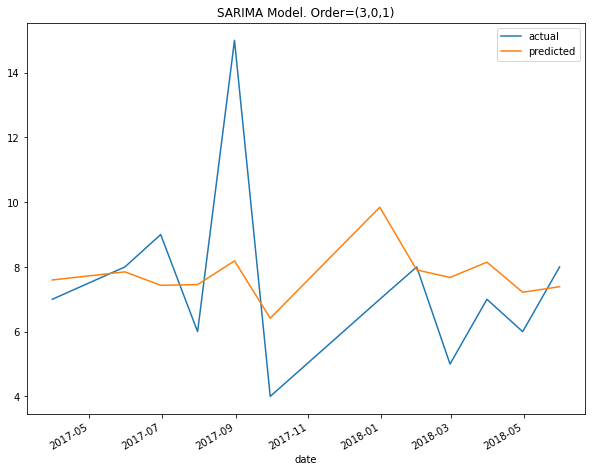

In [81]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res2.actual.plot(figsize=(10,8),legend=True)
df_res2.predicted.plot(legend=True)
plt.title(msg)

In [88]:
future_dates=pd.DataFrame()
future_dates['date']=[     
'2018-05-30',    
'2018-09-30',       
'2018-12-30',   
'2019-01-31',  
'2019-02-28',   
'2019-03-31',
'2019-05-31']      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)

In [89]:
fcast2 = m2.predict(end,end+6).rename('Forecast')
fcast2.index=future_dates.date
print(fcast2)

date
2018-05-30    7.388759
2018-09-30    6.798246
2018-12-30    7.253479
2019-01-31    6.972561
2019-02-28    7.126665
2019-03-31    6.988044
2019-05-31    7.101532
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of neutral sentiment'>

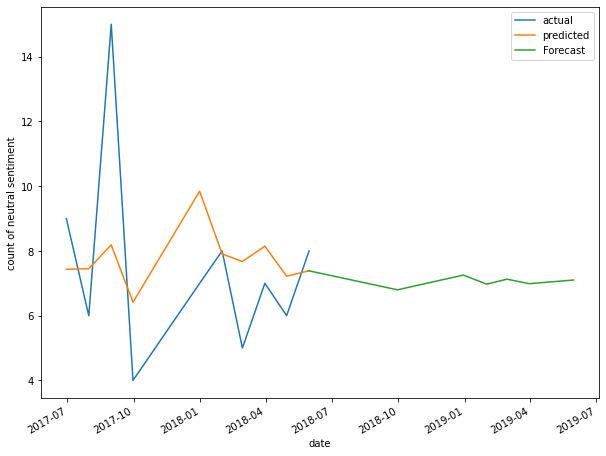

In [91]:
plt.ylabel('count of neutral sentiment')
df_res2.actual.tail(10).plot(figsize=(10,8),legend=True)
df_res2.predicted.tail(10).plot(legend=True)
fcast2.plot(legend=True)

### Negative

In [92]:
office_neg_count=office_neg.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
office_neg_count

,asin,Month,Sentiment,sentiment_count
0,B00006IEEV,1,Negative,8
1,B00006IEEV,2,Negative,7
2,B00006IEEV,3,Negative,4
3,B00006IEEV,4,Negative,10
4,B00006IEEV,5,Negative,5
5,B00006IEEV,6,Negative,6
6,B00006IEEV,7,Negative,4
7,B00006IEEV,8,Negative,8
8,B00006IEEV,9,Negative,6
9,B00006IEEV,10,Negative,4


In [93]:
office_neg=pd.merge(office_neg,office_neg_count)

In [94]:
office_neg=office_neg[['date','sentiment_count']]
office_neg=office_neg.set_index('date')
office_neg=office_neg.sort_values(by=['date'])
office_neg

,sentiment_count
date,
2011-11-18,7
2013-05-20,5
2013-08-26,8
2014-08-11,8
2014-09-27,6
...,...
2018-01-08,8
2018-01-08,8
2018-01-23,8


In [96]:
office_neg=office_neg.resample('M').mean()
office_neg.head()

,sentiment_count
date,
2011-11-30,7.0
2011-12-31,NaN
2012-01-31,NaN
2012-02-29,NaN
2012-03-31,NaN


In [97]:
office_neg.isnull().sum()

sentiment_count    40
dtype: int64

In [98]:
office_neg.dropna(inplace=True)

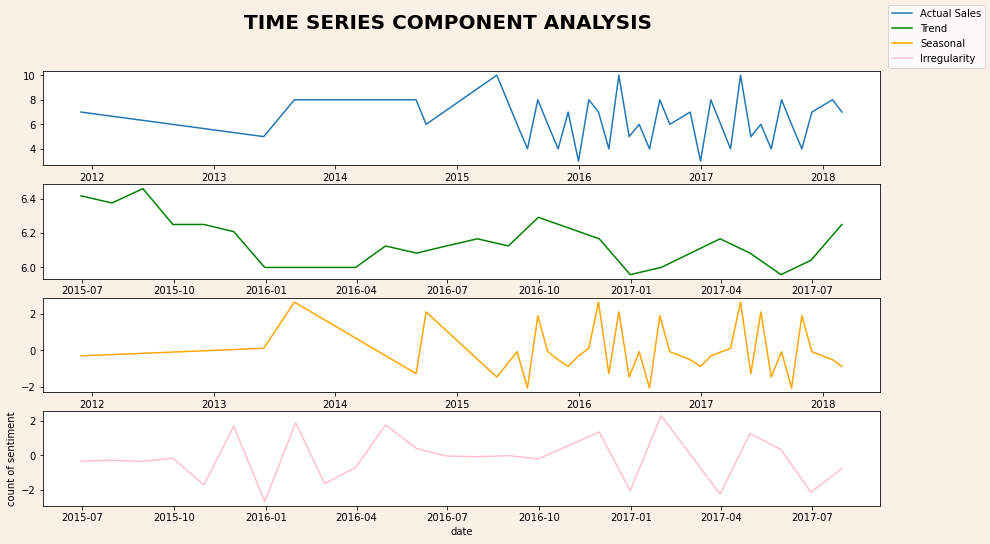

In [99]:
tsa_comp(office_neg)

In [100]:
checkStationarity(office_neg)

pvalue: 6.111318183792052e-16


'Data is Stationary. Proceed to model building'

In [102]:
ratio = 0.7
rows = int(ratio * len(office_neg))
train3 =office_neg[:rows]
test3 = office_neg[rows:]

print("Total={}, Train={}, Test={}".format(len(office_neg), len(train3), len(test3)))

Total=36, Train=25, Test=11


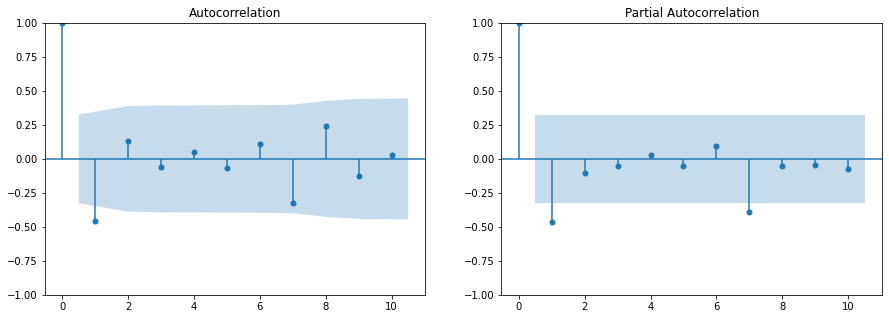

In [103]:
p_and_q(office_neg)

In [116]:
d=0;
lis=[]
for p in range(3):
    for q in range(3):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train3, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model


In [117]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train3), end=len(train3)+len(test3)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test3, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results3 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results3

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",107.908019,110.345771,3.473309,1.863681
1,Model 1,"(0, 0, 1)",104.891173,108.547801,3.397126,1.843129
2,Model 2,"(0, 0, 2)",106.002902,110.878405,3.218326,1.793969
3,Model 3,"(1, 0, 0)",104.637100,108.293728,2.962228,1.721113
4,Model 4,"(1, 0, 1)",106.387558,111.263061,3.157984,1.777072
5,Model 5,"(1, 0, 2)",107.945651,114.040030,3.305664,1.818149
6,Model 6,"(2, 0, 0)",106.200165,111.075668,3.372012,1.836304
7,Model 7,"(2, 0, 1)",108.498260,114.592639,4.009514,2.002377
8,Model 8,"(2, 0, 2)",108.045072,115.358327,5.136122,2.266301


In [118]:
print('Taking model with lowest RMSE score:')
df_results3[df_results3.RMSE==df_results3.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
3,Model 3,"(1, 0, 0)",104.6371,108.293728,2.962228,1.721113


In [119]:
print('Taking model with lowest BIC score:')

df_results3[df_results3.BIC==df_results3.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
3,Model 3,"(1, 0, 0)",104.6371,108.293728,2.962228,1.721113


In [120]:
print('Taking model with lowest AIC score:')
df_results3[df_results3.AIC==df_results3.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
3,Model 3,"(1, 0, 0)",104.6371,108.293728,2.962228,1.721113


In [121]:
p=2;q=2;d=0
P=1;Q=1;D=0
m3 = sm.tsa.statespace.SARIMAX(office_neg['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                   36
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 -75.519
Date:                              Wed, 25 Jan 2023   AIC                            165.038
Time:                                      14:58:21   BIC                            176.123
Sample:                                           0   HQIC                           168.907
                                               - 36                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0026      0.361      0.007      0.994      -0.704       0.709
ar.L2          0.9974      0.361      2.763      0.006       0.290       1.705
ma.L1         -0.0890      0.448     -0.199      0.843      -0.967       0.789
ma.L2         -0.8312      0.455     -1.827      0.068      -1.723       0.061
ar.S.L12       0.4187      1.923      0.218      0.828      -3.351       4.188
ma.S.L12      -0.9147      7.181     -0.127      0.899     -14.989      13.159
sigma2         2.7853     14.193      0.196      0.844     -25.032      30.602
===================================================================================
Ljung-Box (L1) (Q):                   2.67   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.10   Prob(JB):                         0.76
Heteroskedasticity (H):               0.63   Skew:                             0.10
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m3.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [123]:
start = len(train3) 
end = len(train3) + len(test3) - 1

print('start = {}, end = {}'.format(start,end))

start = 25, end = 35


In [124]:
predictions = m3.predict(start,end)
predictions.index=test3.index
print(predictions.head())

date
2017-03-31    5.002803
2017-04-30    6.456644
2017-05-31    5.404794
2017-06-30    6.499433
2017-07-31    4.609743
Name: predicted_mean, dtype: float64


In [125]:
actual = []; pred = []
test3.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test3['sentiment_count'][i])
    pred.append(predictions[i])

df_res3 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res3['error'] = df_res3.actual - df_res3.predicted
df_res3.index=test3.index
print(df_res3.head())

            actual  predicted     error
date                                   
2017-03-31     4.0   5.002803 -1.002803
2017-04-30    10.0   6.456644  3.543356
2017-05-31     5.0   5.404794 -0.404794
2017-06-30     6.0   6.499433 -0.499433
2017-07-31     4.0   4.609743 -0.609743


In [128]:
df_res3.tail(5)

,actual,predicted,error
date,,,
2017-09-30,6.0,6.194965,-0.194965
2017-10-31,4.0,6.659291,-2.659291
2017-11-30,7.0,5.227825,1.772175
2018-01-31,8.0,7.276737,0.723263
2018-02-28,7.0,6.346331,0.653669


In [126]:
mse3=mean_squared_error(df_res3.actual,df_res3.predicted)
rmse3=np.sqrt(mse3)
print('mse:',mse3)
print('rmse:',rmse3)

mse: 2.326377850838405
rmse: 1.5252468163672412


Text(0.5, 1.0, 'SARIMA Model. Order=(2,0,2)')

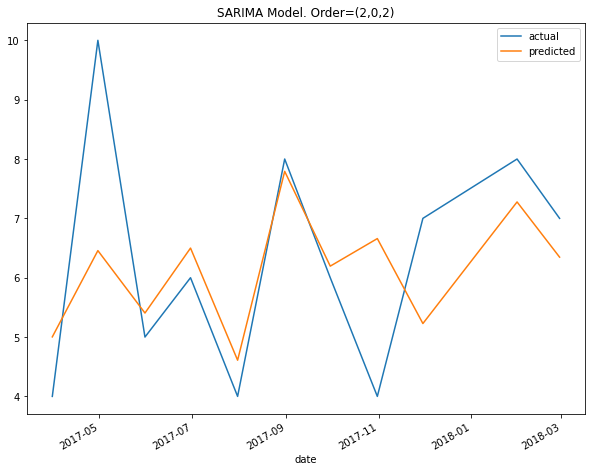

In [127]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res3.actual.plot(figsize=(10,8),legend=True)
df_res3.predicted.plot(legend=True)
plt.title(msg)

In [129]:
future_dates=pd.DataFrame()
future_dates['date']=[     
'2018-02-28',    
'2018-04-30',       
'2018-07-31',   
'2018-12-31',  
'2019-01-31',   
'2019-04-30',
'2019-07-31']      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)

In [133]:
fcast3 = m3.predict(end,end+6).rename('Forecast')
fcast3.index=future_dates.date
print(fcast3.head())

date
2018-02-28    6.346331
2018-04-30    7.299408
2018-07-31    6.046591
2018-12-31    5.197875
2019-01-31    6.278455
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of negative sentiment'>

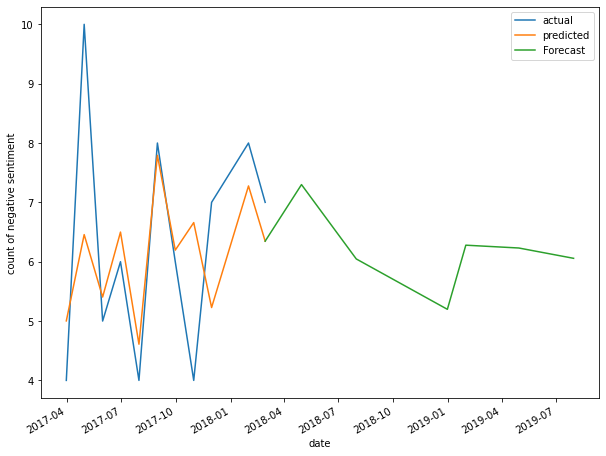

In [134]:
df_res3.actual.tail(20).plot(figsize=(10,8),legend=True)
df_res3.predicted.tail(20).plot(legend=True)
plt.ylabel('count of negative sentiment')
fcast3.plot(legend=True)


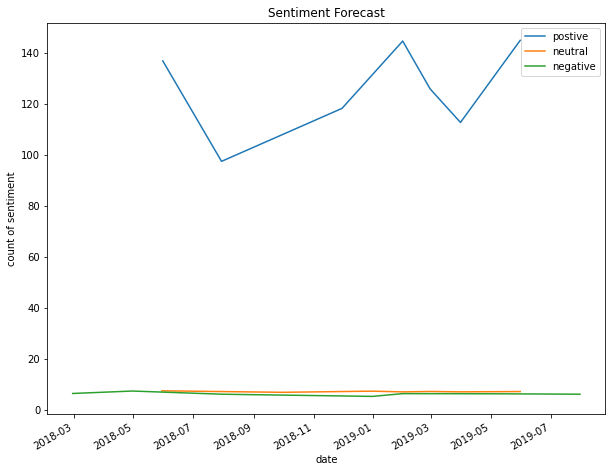

In [135]:
plt.figure(figsize=(10,8))
plt.title('Sentiment Forecast')
plt.ylabel('count of sentiment')
fcast1.plot(label='postive')
fcast2.plot(label='neutral')
fcast3.plot(label='negative')
plt.legend()